In [3]:
import os
import pandas as pd
from CausalInference import perform_causal_inference, summarize_refutations, plot_causal_effects
from data_preprocess import load_config, get_research_topic_data

import warnings
warnings.filterwarnings('ignore')


In [4]:
def ticker2country(df):
    # Define the mapping of tickers to countries
    ticker_country_mapping = {
        "JPM": "United States",
        "BAC": "United States",
        "WFC": "United States",
        "RY": "Canada",
        "HDB": "India",
        "MS": "United States",
        "HSBC": "United Kingdom",
        "GS": "United States",
        "MUFG": "Japan",
        "SCHW": "United States",
        "C": "United States",
        "TD": "Canada",
        "IBN": "India",
        "UBS": "Switzerland",
        "SMFG": "Japan",
        "BNPQY": "France",
        "SAN": "Spain",
        "PNC": "United States",
        "USB": "United States",
        "NU": "Brazil",
        "BNS": "Canada",
        "BMO": "Canada",
        "BBVA": "Spain",
        "ITUB": "Brazil",
        "ING": "Netherlands",
        "TFC": "United States",
        "IBKR": "United States",
        "BK": "United States",
        "BCS": "United Kingdom",
        "BSBR": "Brazil",
        "DB": "Germany",
    }

    df['Country'] = df['ticker'].map(ticker_country_mapping)
    df = pd.get_dummies(df, columns=['Country'], prefix='country', dtype=int)
    return df

def prepare_data():
    # Load datasets
    bank_sector = pd.read_csv('Data/BankSector_ohlcv.csv')
    bank_sector['date'] = pd.to_datetime(bank_sector['date'])

    # Calculate returns
    # Calculate returns
    bank_sector['curr_return'] = bank_sector.groupby('ticker')['close'].pct_change()
    bank_sector['next_return'] = bank_sector.groupby('ticker')['curr_return'].shift(-1)
    
    # Add moving averages
    bank_sector['MA5'] = bank_sector.groupby('ticker')['close'].rolling(window=5).mean().reset_index(0, drop=True)
    bank_sector['MA20'] = bank_sector.groupby('ticker')['close'].rolling(window=20).mean().reset_index(0, drop=True)
    bank_sector['MA50'] = bank_sector.groupby('ticker')['close'].rolling(window=50).mean().reset_index(0, drop=True)
    # Add weekday column
    bank_sector['weekday'] = bank_sector['date'].dt.dayofweek
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    for i, day in enumerate(weekdays):
        bank_sector[day] = (bank_sector['weekday'] == i).astype(int)
    
    # Add is_bulge_brackets flag
    bulge_bracket_banks = ['JPM', 'BAC', 'C', 'GS', 'MS', 'DB', 'UBS', 'BCS']
    bank_sector['is_bulge_brackets'] = bank_sector['ticker'].isin(bulge_bracket_banks).astype(int)
    bank_sector = ticker2country(bank_sector)
    
    return bank_sector.dropna()


In [5]:
df = prepare_data()
config = load_config('config.yaml')
research_topic = 'weekday_effect'
treatments, common_causes, outcome = get_research_topic_data(config, research_topic)

In [6]:
# Perform causal inference
results, refutations = perform_causal_inference(df, treatments, outcome, common_causes)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                         
─────────(E[next_return|country_India,country_Brazil,volume,country_Canada,is_
d[Monday]                                                                     

                                                                              
bulge_brackets,MA50,MA20,country_United States,curr_return,country_United King
                                                                              

                                                                              
dom,country_Netherlands,country_France,country_Germany,country_Switzerland,MA5
                                                                              

                              
,country_Japan,country_Spain])
                              
Estimand assumption 1, Unconfoundedn

Causal Inference Results:
Monday: 0.0012 (95% CI: [0.0007661  0.00154894])
Tuesday: 0.0002 (95% CI: [-0.00016792  0.00058833])
Wednesday: -0.0000 (95% CI: [-0.00039191  0.00036392])
Thursday: -0.0003 (95% CI: [-6.86052151e-04  7.47181530e-05])
Friday: -0.0010 (95% CI: [-0.00137201 -0.00060941])


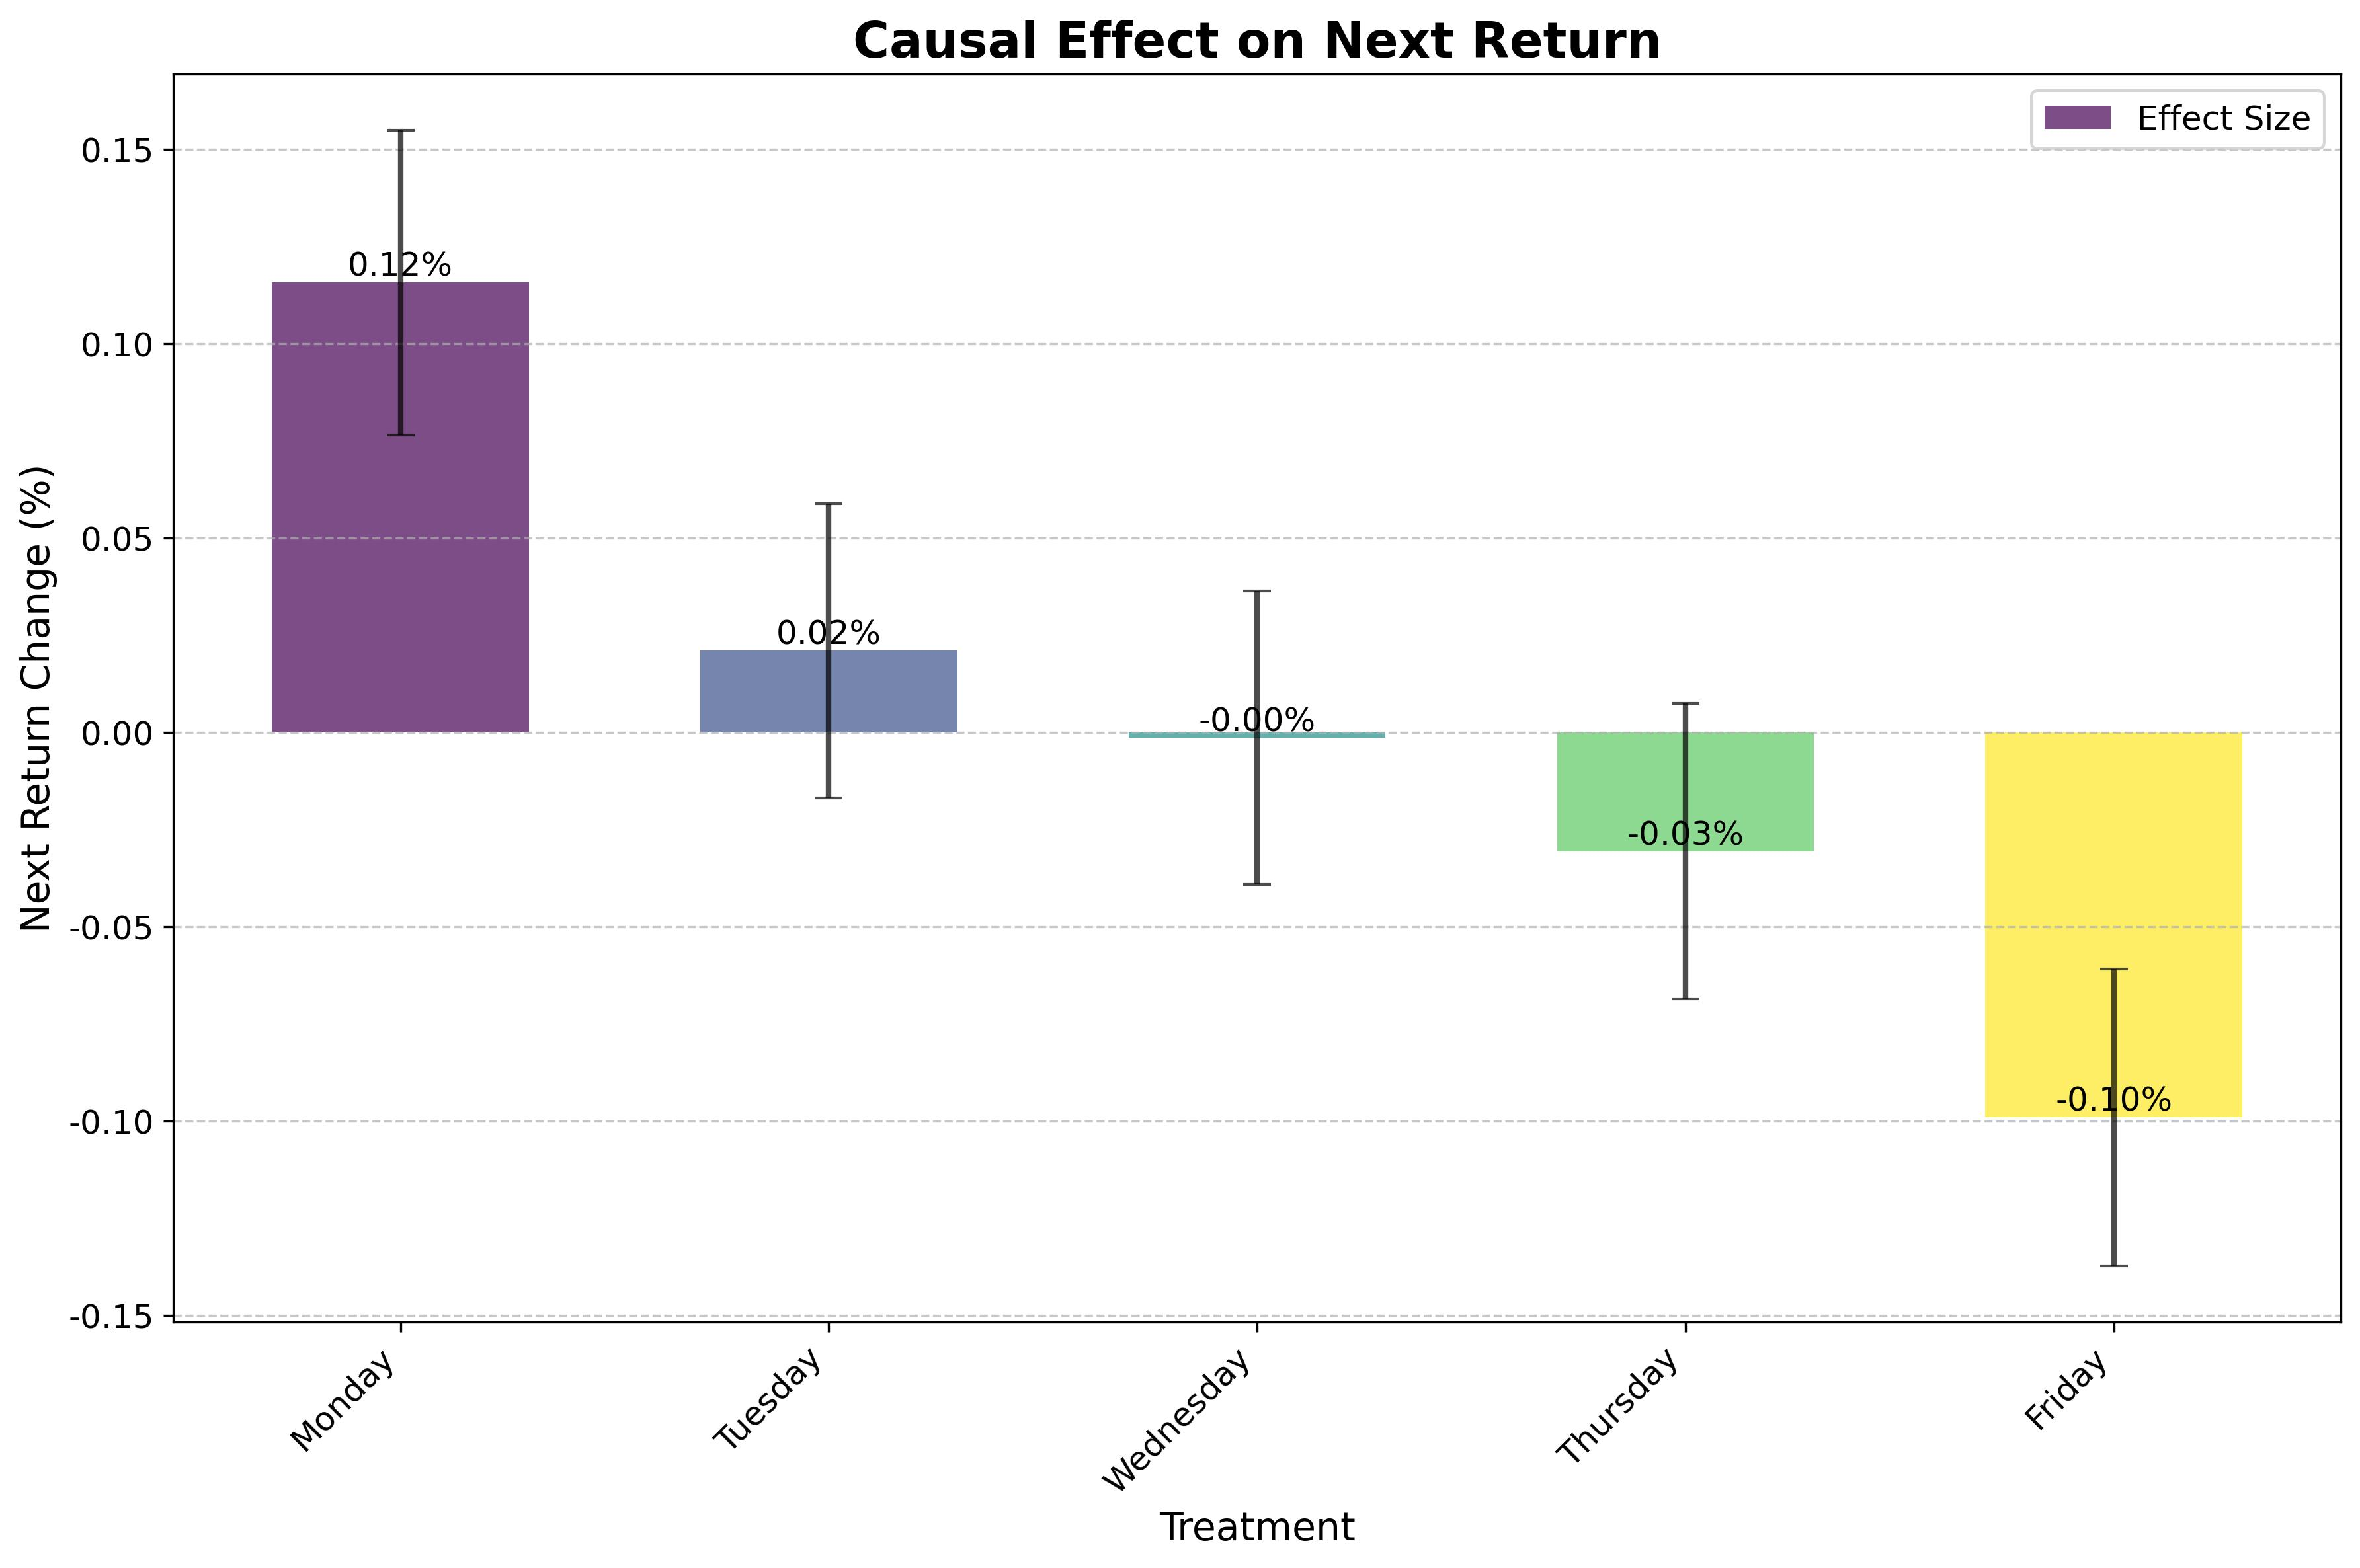

In [7]:
# Summarize refutations
output_dir = config['research_topics'][research_topic]['output_directory']
refutation_summary, interpretation = summarize_refutations(refutations, output_dir)

# Plot causal effects
plot_causal_effects(results, treatments, config, research_topic)

# Print results
print("Causal Inference Results:")
for treatment, estimate in results.items():
    print(f"{treatment}: {estimate.value:.4f} (95% CI: {estimate.get_confidence_intervals()[0]})")

# Display the plot
from IPython.display import Image
Image(filename=os.path.join(output_dir, f'{research_topic}.jpg'))